In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_v2_s

print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


CUDA available: True
Using device: cuda


In [4]:
DATA_DIR = Path(r"C:\Users\96277\Desktop\data-20250915T092833Z-1-001\data")  # مجلّد واحد فيه مجلّدات لكل هوية
assert DATA_DIR.exists(), "تأكد من المسار"

# نقرأ المجلد كـ ImageFolder (يتوقع: DATA_DIR\class_name\*.jpg)
full_ds = datasets.ImageFolder(DATA_DIR)

# تقسيم stratified لكل هوية
indices_by_class = {}
for idx, (_, y) in enumerate(full_ds.samples):
    indices_by_class.setdefault(y, []).append(idx)

train_idx, val_idx = [], []
VAL_RATIO = 0.20
for y, idxs in indices_by_class.items():
    random.shuffle(idxs)
    n_val = max(1, int(len(idxs)*VAL_RATIO))
    val_idx += idxs[:n_val]
    train_idx += idxs[n_val:]

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
class_names = full_ds.classes; NUM_CLASSES = len(class_names)
print(f"👥 classes={NUM_CLASSES}, train={len(train_ds)}, val={len(val_ds)}")

# تحضيرات الصور
IMG=224
train_tf = transforms.Compose([
    transforms.Resize((IMG,IMG)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])
val_tf = transforms.Compose([
    transforms.Resize((IMG,IMG)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

class Wrapped(Dataset):
    def __init__(self, subset, tf): self.subset=subset; self.tf=tf
    def __len__(self): return len(self.subset)
    def __getitem__(self, i):
        x,y = self.subset.dataset[self.subset.indices[i]]
        return self.tf(x), y

train_dl = DataLoader(Wrapped(train_ds, train_tf), batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(Wrapped(val_ds, val_tf),     batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


NameError: name 'Path' is not defined

In [5]:
from pathlib import Path  # 🔑 لازم نستورد Path

# مسار البيانات
DATA_DIR = Path(r"C:\Users\96277\Desktop\data-20250915T092833Z-1-001\data")

# نتأكد إن المسار صحيح
assert DATA_DIR.exists(), f"❌ المسار غير موجود: {DATA_DIR}"
print("✅ البيانات موجودة في:", DATA_DIR)


✅ البيانات موجودة في: C:\Users\96277\Desktop\data-20250915T092833Z-1-001\data


In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# تحويلات أساسية للصور
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# تحميل البيانات
dataset = ImageFolder(root=DATA_DIR, transform=transform)

print("📂 عدد الصور:", len(dataset))
print("📑 عدد الكلاسات:", len(dataset.classes))
print("📝 أسماء الكلاسات:", dataset.classes[:10])  # أول 10 كلاسات


📂 عدد الصور: 15478
📑 عدد الكلاسات: 105
📝 أسماء الكلاسات: ['pins_Adriana Lima', 'pins_Alex Lawther', 'pins_Alexandra Daddario', 'pins_Alvaro Morte', 'pins_Amanda Crew', 'pins_Andy Samberg', 'pins_Anne Hathaway', 'pins_Anthony Mackie', 'pins_Avril Lavigne', 'pins_Ben Affleck']


In [7]:
import os, shutil
from sklearn.model_selection import train_test_split
from pathlib import Path

# المجلد الأساسي
DATA_DIR = Path(r"C:\Users\96277\Desktop\data-20250915T092833Z-1-001\data")
OUTPUT_DIR = Path(r"C:\Users\96277\Desktop\data_split")
(OUTPUT_DIR / "train").mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "val").mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "test").mkdir(parents=True, exist_ok=True)

# تقسيم 70/20/10
for class_name in os.listdir(DATA_DIR):
    class_dir = DATA_DIR / class_name
    if not class_dir.is_dir():
        continue

    images = list(class_dir.glob("*.jpg"))
    train_files, temp_files = train_test_split(images, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.33, random_state=42)

    for split, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
        split_dir = OUTPUT_DIR / split / class_name
        split_dir.mkdir(parents=True, exist_ok=True)
        for f in files:
            shutil.copy(f, split_dir)

print("✅ تم تقسيم الصور في:", OUTPUT_DIR)


✅ تم تقسيم الصور في: C:\Users\96277\Desktop\data_split


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# تحويلات الصور
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# تحميل البيانات
train_ds = datasets.ImageFolder(root=OUTPUT_DIR/"train", transform=train_tfms)
val_ds   = datasets.ImageFolder(root=OUTPUT_DIR/"val", transform=test_tfms)
test_ds  = datasets.ImageFolder(root=OUTPUT_DIR/"test", transform=test_tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32)
test_dl  = DataLoader(test_ds, batch_size=32)

print("✅ DataLoaders جاهزة")


✅ DataLoaders جاهزة


In [11]:
import timm
import torch.nn as nn
import torch

num_classes = len(train_ds.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EfficientNet-B0 مع أوزان جاهزة
model = timm.create_model('efficientnet_b0', pretrained=True)
model.reset_classifier(num_classes=num_classes)

model = model.to(device)
print("✅ Model ready:", type(model).__name__, "| num_classes:", num_classes)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

c:\Users\96277\anaconda3\envs\aiweek\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\96277\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


✅ Model ready: EfficientNet | num_classes: 105


In [12]:
import torch
from tqdm import tqdm

# Loss + Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, train_dl, val_dl, epochs=5):
    for epoch in range(epochs):
        # -------- Training --------
        model.train()
        train_loss, correct, total = 0, 0, 0
        for imgs, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Train Loss: {train_loss/len(train_dl):.4f} | Train Acc: {acc:.2f}%")

        # -------- Validation --------
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_dl, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        acc = 100 * correct / total
        print(f"Val Loss: {val_loss/len(val_dl):.4f} | Val Acc: {acc:.2f}%")
        print("="*60)

# تدريب مبدئي 5 Epochs
train_model(model, train_dl, val_dl, epochs=5)


Epoch 1/5 [Train]: 100%|██████████| 338/338 [02:48<00:00,  2.01it/s]


Train Loss: 3.9030 | Train Acc: 15.66%


Epoch 1/5 [Val]: 100%|██████████| 97/97 [00:20<00:00,  4.66it/s]


Val Loss: 2.8495 | Val Acc: 34.86%


Epoch 2/5 [Train]: 100%|██████████| 338/338 [02:36<00:00,  2.16it/s]


Train Loss: 2.1241 | Train Acc: 53.34%


Epoch 2/5 [Val]: 100%|██████████| 97/97 [00:19<00:00,  5.05it/s]


Val Loss: 1.5264 | Val Acc: 64.04%


Epoch 3/5 [Train]: 100%|██████████| 338/338 [02:37<00:00,  2.14it/s]


Train Loss: 1.0215 | Train Acc: 78.95%


Epoch 3/5 [Val]: 100%|██████████| 97/97 [00:23<00:00,  4.17it/s]


Val Loss: 0.9865 | Val Acc: 76.44%


Epoch 4/5 [Train]: 100%|██████████| 338/338 [02:03<00:00,  2.74it/s]


Train Loss: 0.4613 | Train Acc: 91.78%


Epoch 4/5 [Val]: 100%|██████████| 97/97 [00:15<00:00,  6.39it/s]


Val Loss: 0.7781 | Val Acc: 80.31%


Epoch 5/5 [Train]: 100%|██████████| 338/338 [01:56<00:00,  2.91it/s]


Train Loss: 0.2182 | Train Acc: 96.91%


Epoch 5/5 [Val]: 100%|██████████| 97/97 [00:15<00:00,  6.16it/s]

Val Loss: 0.6776 | Val Acc: 82.70%


In [13]:
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomApply([transforms.ColorJitter(0.2,0.2,0.2,0.1)], p=0.5),
    transforms.ToTensor(),
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# إذا بدك تبدّل الداتالودر الحالية:
# train_ds.transform = train_tfms
# val_ds.transform   = val_tfms
# (أو أنشئ DataLoader من جديد بنفس المسارات)


In [15]:
import torch
from tqdm import tqdm
from pathlib import Path

# ===== إعدادات عامة =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

# مجلد الحفظ
EXP = Path("export")
EXP.mkdir(parents=True, exist_ok=True)
BEST_PATH = EXP / "best_efficientnet_b0.pth"

# AMP لتسريع التدريب
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

best_val_loss = float('inf')
best_val_acc  = 0.0
patience, wait = 4, 0        # EarlyStopping
EPOCHS = 10                  # زِدها إذا بدك

for epoch in range(1, EPOCHS + 1):
    # -------- Train --------
    model.train()
    tr_loss, tr_correct, tr_total = 0.0, 0, 0

    for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS} [Train]"):
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            out  = model(xb)
            loss = criterion(out, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        tr_loss   += loss.item()
        tr_correct += (out.argmax(1) == yb).sum().item()
        tr_total  += yb.size(0)

    tr_acc = 100.0 * tr_correct / max(tr_total, 1)
    tr_loss /= max(len(train_dl), 1)

    # -------- Val --------
    model.eval()
    va_loss, va_correct, va_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in tqdm(val_dl, desc=f"Epoch {epoch}/{EPOCHS} [Val]"):
            xb, yb = xb.to(device), yb.to(device)
            out  = model(xb)
            loss = criterion(out, yb)
            va_loss   += loss.item()
            va_correct += (out.argmax(1) == yb).sum().item()
            va_total  += yb.size(0)

    va_acc = 100.0 * va_correct / max(va_total, 1)
    va_loss /= max(len(val_dl), 1)

    print(f"Train Loss {tr_loss:.4f} | Train Acc {tr_acc:.2f}% | "
          f"Val Loss {va_loss:.4f} | Val Acc {va_acc:.2f}%")

    # -------- Scheduler + EarlyStopping --------
    scheduler.step(va_loss)

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        best_val_acc  = va_acc
        wait = 0
        torch.save(model.state_dict(), BEST_PATH)
        print(f"💾 Saved best weights -> {BEST_PATH}")
    else:
        wait += 1
        if wait >= patience:
            print("⛔ Early stopping (no val loss improvement).")
            break

print(f"✅ Done. Best Val Loss: {best_val_loss:.4f} | Best Val Acc: {best_val_acc:.2f}%")


C:\Users\96277\AppData\Local\Temp\ipykernel_17104\2798560849.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
Epoch 1/10 [Train]:   0%|          | 0/338 [00:00<?, ?it/s]C:\Users\96277\AppData\Local\Temp\ipykernel_17104\2798560849.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Epoch 1/10 [Val]: 100%|██████████| 97/97 [00:17<00:00,  5.47it/s]


Train Loss 0.0590 | Train Acc 99.32% | Val Loss 0.6564 | Val Acc 82.83%
💾 Saved best weights -> export\best_efficientnet_b0.pth


Epoch 2/10 [Val]: 100%|██████████| 97/97 [00:20<00:00,  4.68it/s]


Train Loss 0.0425 | Train Acc 99.37% | Val Loss 0.6431 | Val Acc 83.63%
💾 Saved best weights -> export\best_efficientnet_b0.pth


Epoch 3/10 [Val]: 100%|██████████| 97/97 [00:21<00:00,  4.43it/s]


Train Loss 0.0295 | Train Acc 99.64% | Val Loss 0.6630 | Val Acc 83.31%


Epoch 4/10 [Val]: 100%|██████████| 97/97 [00:15<00:00,  6.25it/s]


Train Loss 0.0302 | Train Acc 99.55% | Val Loss 0.6157 | Val Acc 84.64%
💾 Saved best weights -> export\best_efficientnet_b0.pth


Epoch 5/10 [Val]: 100%|██████████| 97/97 [00:15<00:00,  6.29it/s]


Train Loss 0.0261 | Train Acc 99.51% | Val Loss 0.6303 | Val Acc 84.05%


Epoch 6/10 [Val]: 100%|██████████| 97/97 [00:13<00:00,  7.29it/s]


Train Loss 0.0278 | Train Acc 99.50% | Val Loss 0.6467 | Val Acc 83.73%


Epoch 7/10 [Val]: 100%|██████████| 97/97 [00:15<00:00,  6.37it/s]


Train Loss 0.0268 | Train Acc 99.43% | Val Loss 0.6881 | Val Acc 84.05%


Epoch 8/10 [Val]: 100%|██████████| 97/97 [00:14<00:00,  6.68it/s]


Train Loss 0.0139 | Train Acc 99.85% | Val Loss 0.5726 | Val Acc 86.15%
💾 Saved best weights -> export\best_efficientnet_b0.pth


Epoch 9/10 [Val]: 100%|██████████| 97/97 [00:13<00:00,  6.97it/s]


Train Loss 0.0101 | Train Acc 99.91% | Val Loss 0.5723 | Val Acc 86.18%
💾 Saved best weights -> export\best_efficientnet_b0.pth


Epoch 10/10 [Val]: 100%|██████████| 97/97 [00:17<00:00,  5.63it/s]


Train Loss 0.0078 | Train Acc 99.91% | Val Loss 0.5615 | Val Acc 86.12%
💾 Saved best weights -> export\best_efficientnet_b0.pth
✅ Done. Best Val Loss: 0.5615 | Best Val Acc: 86.12%


C:\Users\96277\AppData\Local\Temp\ipykernel_17104\3662662510.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(EXP/"best_efficientnet_b0.p

✅ Test Accuracy: 0.8572327044025158

                              precision    recall  f1-score   support

          pins_Adriana Lima       1.00      0.89      0.94        19
          pins_Alex Lawther       0.88      1.00      0.93        14
    pins_Alexandra Daddario       0.90      0.95      0.93        20
          pins_Alvaro Morte       0.79      0.85      0.81        13
           pins_Amanda Crew       0.88      0.64      0.74        11
          pins_Andy Samberg       0.82      1.00      0.90        18
         pins_Anne Hathaway       0.94      0.83      0.88        18
        pins_Anthony Mackie       1.00      1.00      1.00        11
         pins_Avril Lavigne       0.93      0.93      0.93        15
           pins_Ben Affleck       0.86      0.50      0.63        12
            pins_Bill Gates       1.00      1.00      1.00        11
          pins_Bobby Morley       0.59      0.77      0.67        13
      pins_Brenton Thwaites       0.94      0.89      0.92      

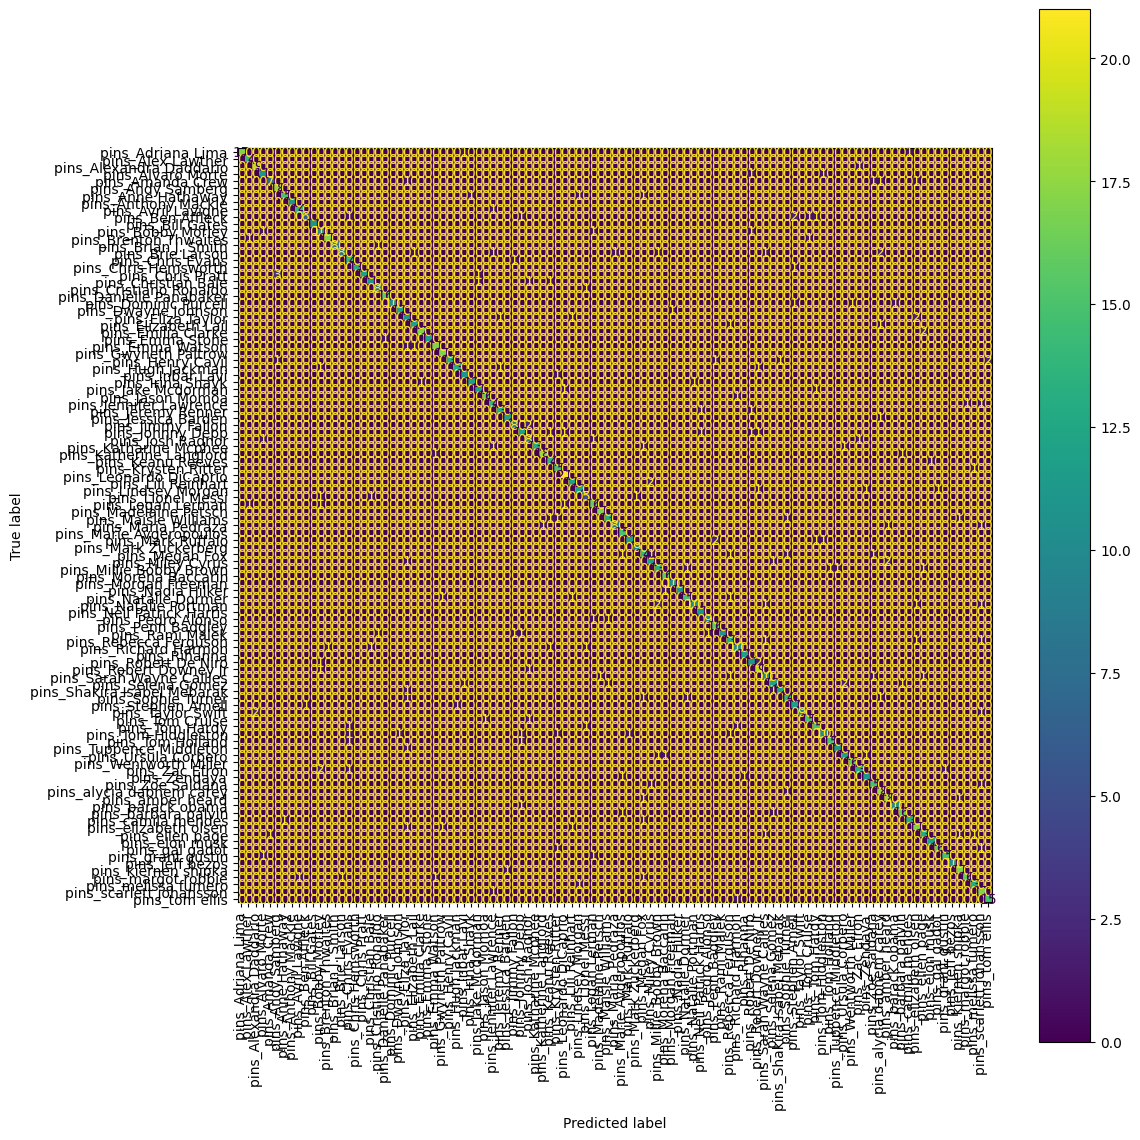

In [16]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from pathlib import Path
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EXP = Path("export")
model.load_state_dict(torch.load(EXP/"best_efficientnet_b0.pth", map_location=device))
model.eval()

all_true, all_pred = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        pred = model(xb).argmax(1).cpu().numpy()
        all_pred.append(pred); all_true.append(yb.numpy())

all_true = np.concatenate(all_true); all_pred = np.concatenate(all_pred)

print("✅ Test Accuracy:", (all_true == all_pred).mean())
print("\n", classification_report(all_true, all_pred, target_names=train_ds.classes))

cm = confusion_matrix(all_true, all_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=train_ds.classes)
fig = disp.plot(xticks_rotation=90).figure_
fig.set_size_inches(12, 12)
Path("runs").mkdir(exist_ok=True)
plt.tight_layout(); plt.savefig("runs/cm_test.png", dpi=200); plt.show()


In [18]:
from pathlib import Path

# إنشاء مجلد export
EXP = Path("export")
EXP.mkdir(exist_ok=True)
print("📂 Created:", EXP.resolve())


📂 Created: C:\Users\96277\AppData\Local\Programs\Microsoft VS Code\export


In [19]:
torch.save(model.state_dict(), EXP / "best_efficientnet_b0.pth")
print("💾 Saved:", EXP/"best_efficientnet_b0.pth")


💾 Saved: export\best_efficientnet_b0.pth


In [20]:
with open(EXP/"class_names.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(train_ds.classes))
print("💾 Saved:", EXP/"class_names.txt")


💾 Saved: export\class_names.txt


In [21]:
import json, numpy as np, torch
from pathlib import Path
EXP = Path("export"); EXP.mkdir(exist_ok=True)

model.eval()
val_probs=[]
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        val_probs.append(torch.softmax(model(xb), dim=1).cpu().numpy())

val_probs = np.concatenate(val_probs)       # (N, C)
maxp = val_probs.max(axis=1)                # أعلى احتمال لكل عينة

thr = float(np.percentile(maxp, 15))        # عتبة مقترحة (تقدر تغيّرها 10–20%)
json.dump({"max_softmax_threshold": thr}, open(EXP/"threshold.json","w"), indent=2)
open(EXP/"class_names.txt","w",encoding="utf-8").write("\n".join(train_ds.classes))
print("🔐 threshold =", round(thr,3))


🔐 threshold = 0.742


In [22]:
import json
thr = 0.742  # تقدر تعدل حسب نتائجك
json.dump({"max_softmax_threshold": thr}, open(EXP/"threshold.json","w"), indent=2)
print("💾 Saved threshold.json with", thr)


💾 Saved threshold.json with 0.742


In [23]:
dummy = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(
    model, dummy, EXP/"faceid_efficientnet_b0.onnx",
    input_names=["images"], output_names=["logits"],
    opset_version=17,
    dynamic_axes={"images": {0: "batch"}, "logits": {0: "batch"}}
)
print("💾 Exported:", EXP/"faceid_efficientnet_b0.onnx")


💾 Exported: export\faceid_efficientnet_b0.onnx


In [25]:
import json, numpy as np, torch, os
os.makedirs("export", exist_ok=True)

# تنبؤات Val لاحتمالات Softmax
model.eval()
val_probs=[]
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        prob = torch.softmax(model(xb), dim=1).cpu().numpy()
        val_probs.append(prob)
val_probs = np.concatenate(val_probs)
maxp = val_probs.max(axis=1)

# اختيار عتبة مناسبة (مثلاً المئين 10–20% من maxp)
thr = float(np.percentile(maxp, 15))
with open("export/threshold.json","w") as f:
    json.dump({"max_softmax_threshold": thr}, f, indent=2)

with open("export/class_names.txt","w",encoding="utf-8") as f:
    f.write("\n".join(train_ds.classes))

print("🔐 threshold =", round(thr,3))
print("💾 class_names.txt + threshold.json saved")


🔐 threshold = 0.742
💾 class_names.txt + threshold.json saved


In [26]:
import os, json, torch, zipfile
import numpy as np
from pathlib import Path

# 🔹 المجلد اللي بدنا نخزن فيه
EXP = Path("export"); EXP.mkdir(exist_ok=True)

# 1) حفظ أفضل وزن .pth
torch.save(model.state_dict(), EXP/"best_efficientnet_b0.pth")
print("💾 Saved:", EXP/"best_efficientnet_b0.pth")

# 2) حفظ أسماء الكلاسات
with open(EXP/"class_names.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(train_ds.classes))
print("📄 Saved:", EXP/"class_names.txt")

# 3) حساب threshold من الـ validation
model.eval()
val_probs = []
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        prob = torch.softmax(model(xb), dim=1).cpu().numpy()
        val_probs.append(prob)

val_probs = np.concatenate(val_probs)
maxp = val_probs.max(axis=1)
thr = float(np.percentile(maxp, 15))  # ممكن تغير 15 → 10 أو 20 حسب التجربة

with open(EXP/"threshold.json", "w") as f:
    json.dump({"max_softmax_threshold": thr}, f, indent=2)
print("🔑 Saved:", EXP/"threshold.json", "| value =", round(thr, 3))

# 4) تحويل ONNX (اختياري)
dummy = torch.randn(1, 3, 224, 224).to(device)  # حجم الصورة 224x224
onnx_path = EXP/"best_efficientnet_b0.onnx"
torch.onnx.export(model, dummy, onnx_path,
                  input_names=["images"], output_names=["logits"],
                  dynamic_axes={"images": {0: "batch"}, "logits": {0: "batch"}},
                  opset_version=12)
print("🔗 Saved:", onnx_path)

# 5) ضغط كل الملفات بملف zip
zip_path = "model_export.zip"
with zipfile.ZipFile(zip_path, "w") as zipf:
    for file in EXP.iterdir():
        zipf.write(file, arcname=file.name)
print("📦 Export ready:", zip_path)


💾 Saved: export\best_efficientnet_b0.pth
📄 Saved: export\class_names.txt
🔑 Saved: export\threshold.json | value = 0.742
🔗 Saved: export\best_efficientnet_b0.onnx
📦 Export ready: model_export.zip


In [27]:
import shutil
from pathlib import Path

# مسار الملفات الحالية
EXP = Path("export")

# مسار سطح المكتب
desktop = Path(r"C:\Users\96277\Desktop")

# انسخ كل ملف مهم لسطح المكتب
files_to_copy = [
    "best_efficientnet_b0.pth",
    "best_efficientnet_b0.onnx",
    "class_names.txt",
    "threshold.json",
    "model_export.zip"
]

for fname in files_to_copy:
    src = EXP / fname
    dst = desktop / fname
    if src.exists():
        shutil.copy(src, dst)
        print(f"✅ Copied {fname} to Desktop")
    else:
        print(f"⚠️ File not found: {fname}")


✅ Copied best_efficientnet_b0.pth to Desktop
✅ Copied best_efficientnet_b0.onnx to Desktop
✅ Copied class_names.txt to Desktop
✅ Copied threshold.json to Desktop
⚠️ File not found: model_export.zip


In [5]:
from torchvision import datasets, transforms
from pathlib import Path

OUTPUT_DIR = Path(r"C:\Users\96277\Desktop\data_split")

train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(root=OUTPUT_DIR/"train", transform=train_tfms)

# هسه كود المابينغ رح يشتغل
cto = train_ds.class_to_idx
itc = {v:k for k,v in cto.items()}

import json
EXP = Path("export"); EXP.mkdir(exist_ok=True)

json.dump(cto, open(EXP/"class_to_idx.json","w",encoding="utf-8"), ensure_ascii=False, indent=2)
json.dump(itc, open(EXP/"idx_to_class.json","w",encoding="utf-8"), ensure_ascii=False, indent=2)

print("✅ Saved:", (EXP/"class_to_idx.json").resolve())
print("✅ Saved:", (EXP/"idx_to_class.json").resolve())


✅ Saved: C:\Users\96277\Desktop\export\class_to_idx.json
✅ Saved: C:\Users\96277\Desktop\export\idx_to_class.json
